In [113]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

from twitpol import config, utils

sns.set(style='whitegrid')
%matplotlib inline

In [114]:
datadir = config.DATA / 'big_data'
pd.read_csv('/home/ubuntu/twitter-polling/data/big_data/BIDEN.csv')
dfs = []
for f in datadir.glob('*.csv'):
    if 'ALL' in str(f):
        continue
    name = str(f.stem).split('.')[0]
    df = pd.read_csv(f, index_col=0)
    df['candidate'] = name
    dfs.append(df)
    
df_all = pd.concat(dfs, axis=0)
df_all

,Date,Ground truth,Relative diff ground truth,Number of tweets (ALL),weighted_sentiments (ALL tweets),Number of tweets (likes >= 1),weighted_sentiments(likes >= 1),Number of tweets (likes >= 10),weighted_sentiments(likes >= 10),Number of tweets (likes >= 100),weighted_sentiments(likes >= 100),Number of tweets sent_cutoff = 0,weighted_sentiments sent_cutoff = 0,Number of tweets sent_cutoff = 0.1,weighted_sentiments sent_cutoff = 0.1,Number of tweets sent_cutoff = 0.2,weighted_sentiments sent_cutoff = 0.2,Number of tweets sent_cutoff = 0.3,weighted_sentiments sent_cutoff = 0.3,candidate
0,2019-03-01,33.835539,NaN,2861.0,0.620326,1192.0,0.620326,232.0,0.628818,40.0,0.651440,2861.0,0.620326,2183.0,0.634314,1536.0,0.651817,893.0,0.678672,BIDEN
1,2019-03-02,33.835539,0.0,2821.0,0.498847,987.0,0.498847,128.0,0.501428,22.0,0.506860,2821.0,0.498847,2150.0,0.275975,1374.0,0.228187,736.0,0.150881,BIDEN
2,2019-03-03,33.835539,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BIDEN
3,2019-03-04,33.835539,0.0,1780.0,0.555393,568.0,0.555393,73.0,0.558884,14.0,0.566936,1780.0,0.555393,1342.0,0.566073,913.0,0.771697,549.0,0.851750,BIDEN
4,2019-03-05,33.835539,0.0,40.0,0.442847,14.0,0.442847,1.0,0.376607,NaN,NaN,40.0,0.442847,37.0,0.434368,27.0,0.530530,20.0,0.583529,BIDEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2019-07-07,16.819153,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SANDERS
126,2019-07-08,16.819153,0.0,1900.0,0.480786,863.0,0.480786,147.0,0.480831,24.0,0.456818,1900.0,0.480786,1479.0,0.450610,1105.0,0.532886,683.0,0.523995,SANDERS
127,2019-07-09,16.819153,0.0,580.0,0.331681,249.0,0.331681,47.0,0.314468,10.0,0.298230,580.0,0.331681,454.0,0.303636,322.0,0.181755,211.0,0.157290,SANDERS
128,2019-07-10,16.819153,0.0,3309.0,0.491682,1508.0,0.491682,205.0,0.495506,20.0,0.501952,3309.0,0.491682,2541.0,0.487659,1892.0,0.516926,1215.0,0.580561,SANDERS


In [115]:
df_all.columns.tolist()

['Date',
 'Ground truth',
 'Relative diff ground truth',
 'Number of tweets (ALL)',
 'weighted_sentiments (ALL tweets)',
 'Number of tweets (likes >= 1)',
 'weighted_sentiments(likes >= 1)',
 'Number of tweets (likes >= 10)',
 'weighted_sentiments(likes >= 10)',
 'Number of tweets (likes >= 100)',
 'weighted_sentiments(likes >= 100)',
 'Number of tweets sent_cutoff = 0',
 'weighted_sentiments sent_cutoff = 0',
 'Number of tweets sent_cutoff = 0.1',
 'weighted_sentiments sent_cutoff = 0.1',
 'Number of tweets sent_cutoff = 0.2',
 'weighted_sentiments sent_cutoff = 0.2',
 'Number of tweets sent_cutoff = 0.3',
 'weighted_sentiments sent_cutoff = 0.3',
 'candidate']

In [126]:
# One hot encoding for candidate
onehot = OneHotEncoder()
candidates = pd.DataFrame(onehot.fit_transform(df_all[['candidate']]).toarray()).astype(int)
df_all[[c.split('_')[1] for c in onehot.get_feature_names()]] = candidates

# Creating column for last day's lag + last day's ground truth
df_all = (df_all.groupby('candidate')
          .apply(lambda df: (df.assign(lag_last_day=lambda x: x['Relative diff ground truth'].shift(1, fill_value=0),
                                       ground_truth_last_day=lambda x: x['Ground truth'].shift(1, fill_value=0))))
          .reset_index(drop=True))

# Also adding a column for 5 and 10 days in advance
df_all = (df_all.groupby('candidate')
          .apply(lambda df: (df.assign(ground_truth5=lambda x: x['Ground truth'].shift(-5),
                                       ground_truth10=lambda x: x['Ground truth'].shift(-10)
                                      )))
          .reset_index(drop=True))

# Dropping rows with NaN counts
df_all = df_all.dropna(subset=['Number of tweets (ALL)'])

# And then filling NaN for lags and dropping index
df_all = df_all.fillna(value=0)


In [127]:
df_all

,Date,Ground truth,Relative diff ground truth,Number of tweets (ALL),weighted_sentiments (ALL tweets),Number of tweets (likes >= 1),weighted_sentiments(likes >= 1),Number of tweets (likes >= 10),weighted_sentiments(likes >= 10),Number of tweets (likes >= 100),...,Number of tweets sent_cutoff = 0.3,weighted_sentiments sent_cutoff = 0.3,candidate,BIDEN,SANDERS,WARREN,lag_last_day,ground_truth_last_day,ground_truth5,ground_truth10
0,2019-03-01,33.835539,0.000000,2861.0,0.620326,1192.0,0.620326,232.0,0.628818,40.0,...,893.0,0.678672,BIDEN,1.0,0.0,0.0,0.000000,0.000000,33.835539,33.835539
1,2019-03-02,33.835539,0.000000,2821.0,0.498847,987.0,0.498847,128.0,0.501428,22.0,...,736.0,0.150881,BIDEN,1.0,0.0,0.0,0.000000,33.835539,33.835539,33.835539
2,2019-03-04,33.835539,0.000000,1780.0,0.555393,568.0,0.555393,73.0,0.558884,14.0,...,549.0,0.851750,BIDEN,1.0,0.0,0.0,0.000000,33.835539,33.835539,33.835539
3,2019-03-05,33.835539,0.000000,40.0,0.442847,14.0,0.442847,1.0,0.376607,0.0,...,20.0,0.583529,BIDEN,1.0,0.0,0.0,0.000000,33.835539,33.835539,33.835539
4,2019-03-08,33.835539,0.000000,2214.0,0.410616,747.0,0.410616,122.0,0.403089,15.0,...,663.0,0.380356,BIDEN,1.0,0.0,0.0,0.000000,33.835539,33.835539,33.835539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,2019-10-11,19.778300,-0.005133,3091.0,0.435031,1290.0,0.253874,325.0,0.248350,57.0,...,1130.0,0.189869,WARREN,0.0,0.0,0.0,-0.009122,19.880339,0.000000,0.000000
434,2019-10-12,19.761830,-0.000833,2037.0,0.548128,1907.0,0.409793,464.0,0.409047,115.0,...,2012.0,0.233820,WARREN,0.0,0.0,0.0,-0.005133,19.778300,0.000000,0.000000
435,2019-10-13,19.875809,0.005768,1780.0,0.518965,245.0,0.459468,67.0,0.459194,8.0,...,232.0,0.482785,WARREN,0.0,0.0,0.0,-0.000833,19.761830,0.000000,0.000000
436,2019-10-23,20.623695,0.001668,5765.0,0.406066,637.0,0.574801,140.0,0.580069,29.0,...,673.0,0.637283,WARREN,0.0,0.0,0.0,0.005768,19.875809,0.000000,0.000000


In [128]:
X_train, X_test, y_train, y_test = train_test_split(df_all.drop(['Ground truth', 'Date', 'candidate', 'ground_truth5', 'ground_truth10'], axis=1), df_all[['Ground truth', 'ground_truth5', 'ground_truth10']], test_size=0.3, stratify=df_all['candidate'])
y_train, y_train5, y_train10 = y_train['Ground truth'], y_train['ground_truth5'], y_train['ground_truth10']
y_test, y_test5, y_test10 = y_test['Ground truth'], y_test['ground_truth5'], y_test['ground_truth10']


In [129]:
kbest = SelectKBest(f_regression)
X_best = kbest.fit_transform(X_train, y_train)

In [130]:
np.sort(kbest.scores_)

array([6.10521700e-03, 1.07618494e-02, 4.77370373e-02, 1.00362235e-01,
       1.93853003e-01, 2.11449908e-01, 3.05932038e-01, 3.13261144e-01,
       2.72419106e+00, 3.87660756e+00, 3.87660756e+00, 4.54136248e+00,
       5.39008459e+00, 8.46418205e+00, 9.20346664e+00, 1.28120338e+01,
       1.52364452e+01, 1.58429770e+01, 2.97000440e+01, 1.16908258e+02,
       3.53476922e+02, 6.49024587e+03])

In [131]:
ranked_feats = X_train.columns[np.argsort(kbest.scores_)[::-1]]
li = [print(f'{score:.3f} \t {featname}') for score, featname in zip(np.sort(kbest.scores_)[::-1], ranked_feats)]

6490.246 	 ground_truth_last_day
353.477 	 BIDEN
116.908 	 WARREN
29.700 	 SANDERS
15.843 	 weighted_sentiments sent_cutoff = 0.3
15.236 	 weighted_sentiments (ALL tweets)
12.812 	 weighted_sentiments(likes >= 100)
9.203 	 weighted_sentiments sent_cutoff = 0.2
8.464 	 weighted_sentiments sent_cutoff = 0.1
5.390 	 weighted_sentiments(likes >= 10)
4.541 	 Relative diff ground truth
3.877 	 weighted_sentiments sent_cutoff = 0
3.877 	 weighted_sentiments(likes >= 1)
2.724 	 lag_last_day
0.313 	 Number of tweets (likes >= 10)
0.306 	 Number of tweets (ALL)
0.211 	 Number of tweets (likes >= 100)
0.194 	 Number of tweets sent_cutoff = 0
0.100 	 Number of tweets sent_cutoff = 0.1
0.048 	 Number of tweets sent_cutoff = 0.3
0.011 	 Number of tweets sent_cutoff = 0.2
0.006 	 Number of tweets (likes >= 1)


So, the features used will be:

* Ground truth on the last day
* Weighted sentiment of all tweets
* Relative difference in ground truth
* The lag the day before
* Total number of tweets
* Interaction between number of tweets and weighted sentiment of all tweets

In [132]:
feats = ['ground_truth_last_day',
         'weighted_sentiments (ALL tweets)',
         'Relative diff ground truth',
         'lag_last_day',
         'Number of tweets (ALL)',
         'WARREN',
         'SANDERS',
         'BIDEN'
        ]

X_train_feats = X_train[feats]
X_test_feats = X_test[feats]

new_colnames = ['ground_truth_prev', 'weighted_sent', 'ground_truth_lag1', 'ground_truth_lag2', 'n_tweets', 'warren', 'sanders', 'biden']
X_train_feats.columns = new_colnames
X_test_feats.columns = new_colnames

X_train_feats['sentiment#count'] = X_train_feats['weighted_sent'] * X_train_feats['n_tweets']
X_test_feats['sentiment#count'] = X_test_feats['weighted_sent'] * X_test_feats['n_tweets']

/home/ubuntu/miniconda3/envs/twitpol-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/twitpol-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


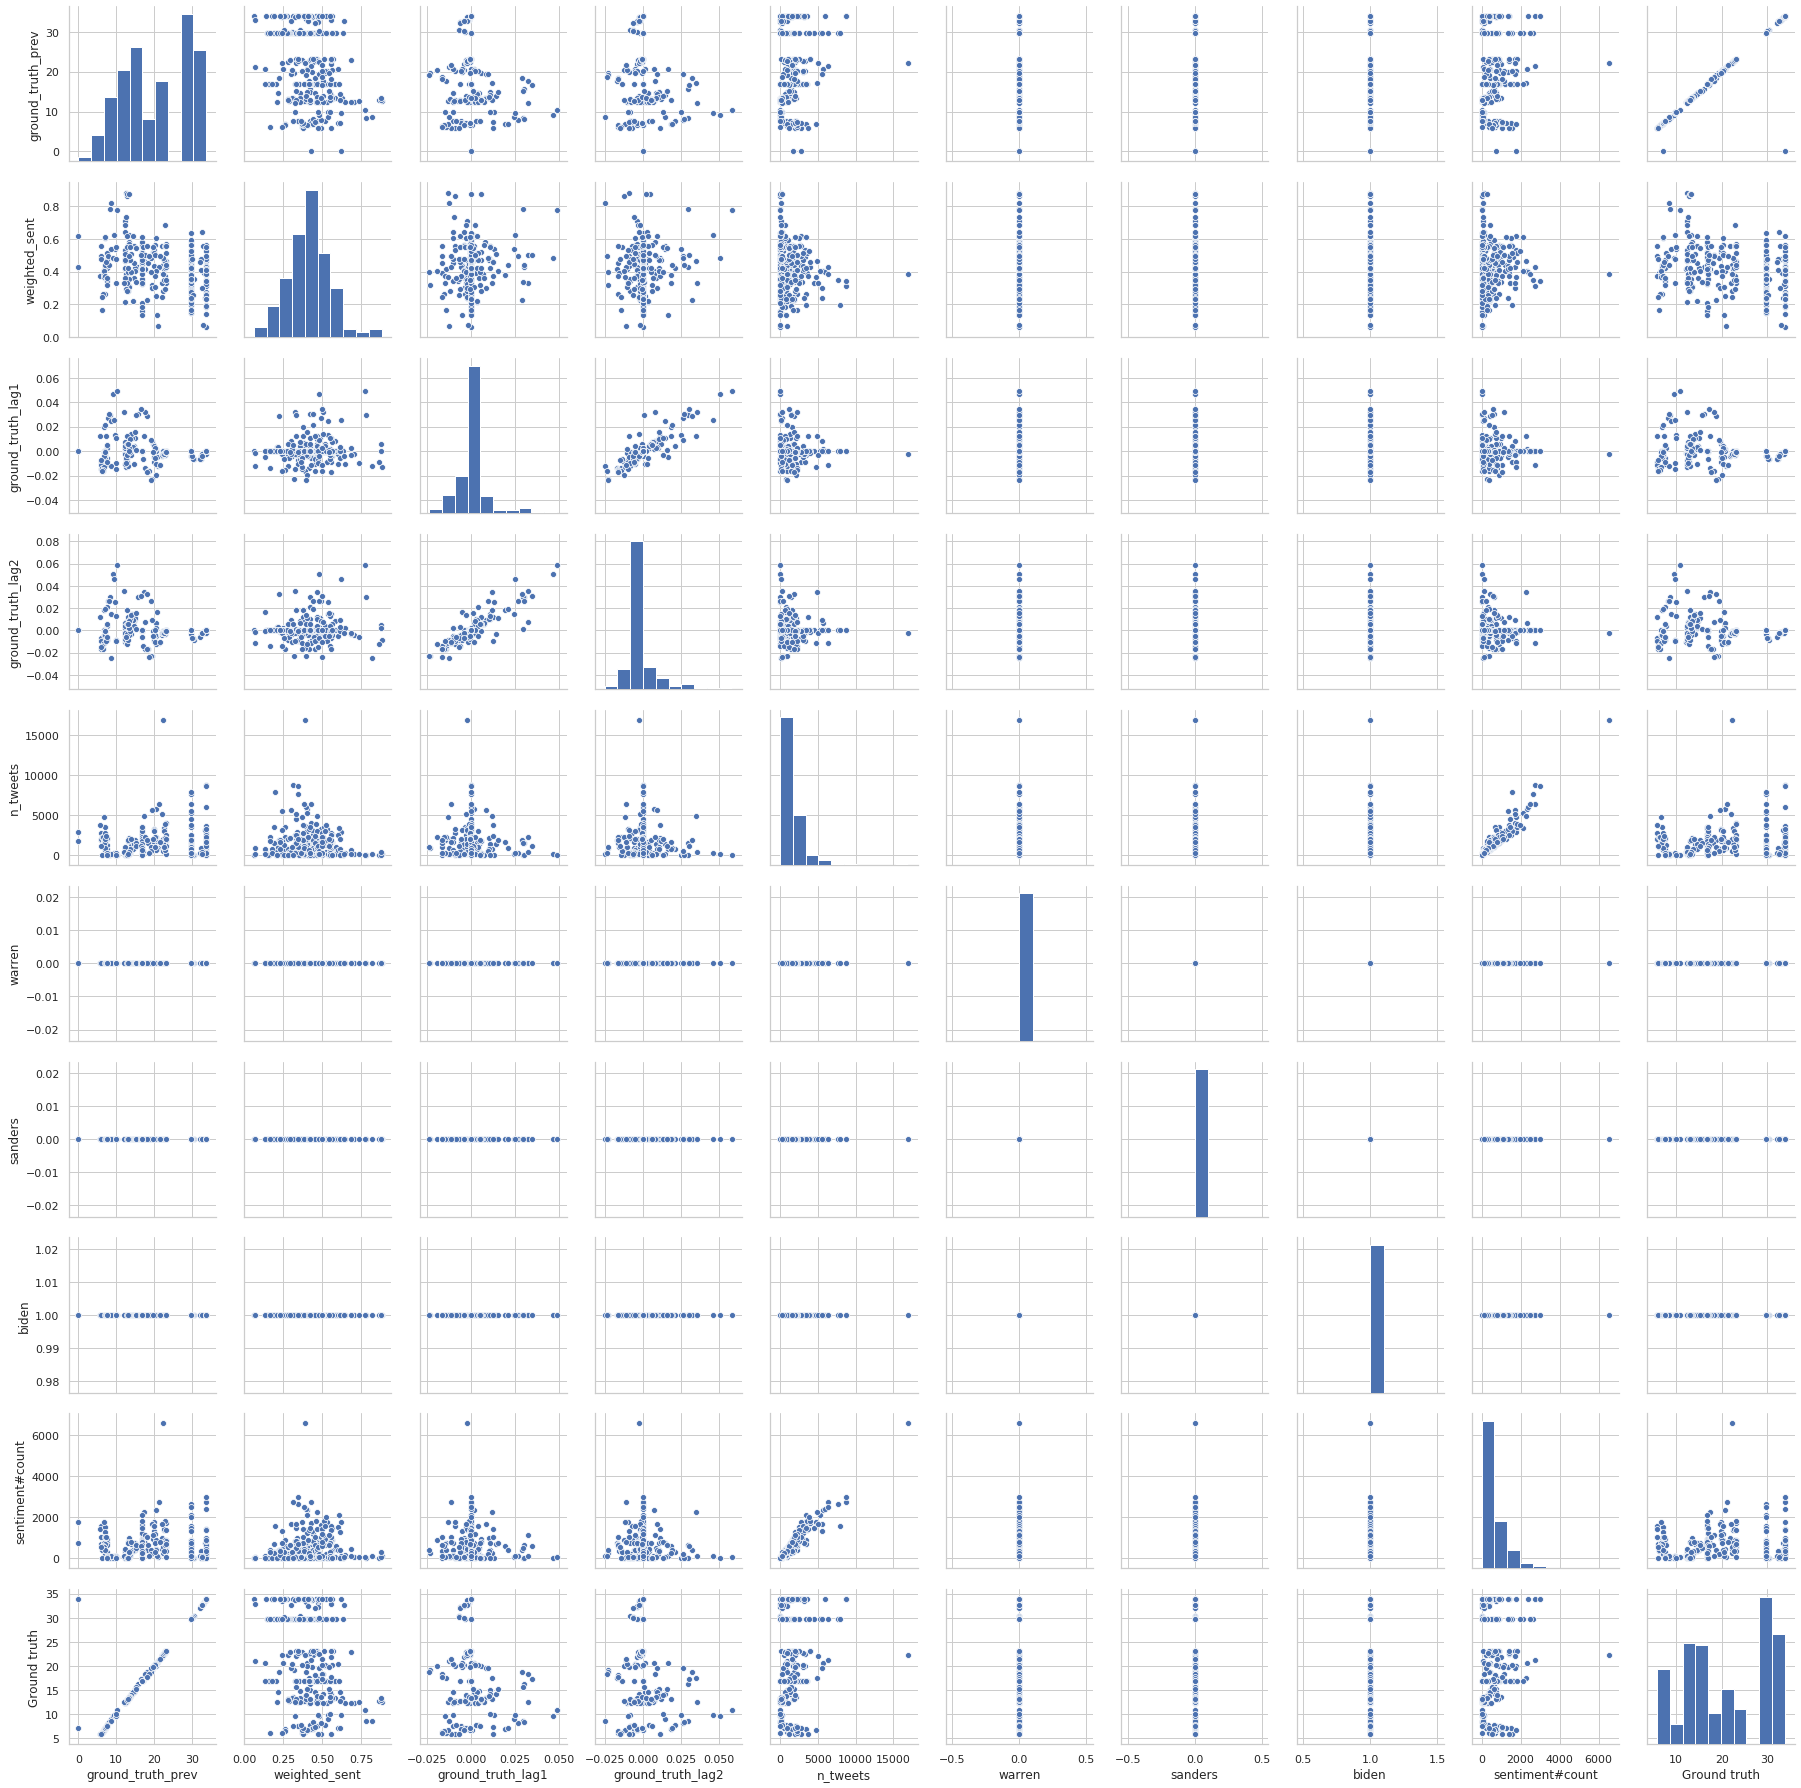

In [123]:
sns.pairplot(pd.concat((X_train_feats, y_train), axis=1))
plt.show()

### Modelling

**Goal:** We want to fit a model such that for any day, given features extracted from Twitter and the candidate's performance in the polls in the last couple of days, we can predict how the candidate will perform today.

**Models to try:**

Linear models

* Linear regression
* Regularized linear regression (ridge, lasso)

Ensemble

* Random Forest
* Boosting

Time series
* ARIMA time series

In [133]:
alphas = np.logspace(np.log(0.4), np.log(5), 5)
models = [
    ('linear regression', LinearRegression()),
    ('ridge', RidgeCV(alphas=alphas)),
    ('LASSO', LassoCV()),
    ('random forest', RandomForestRegressor(n_estimators=100, max_depth=3)),
    ('AdaBoost', AdaBoostRegressor())
]

def fit_and_score_model(model, X_train, y_train, X_test, y_test):
    fitted_model = model.fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)
    
    r2_train = r2_score(y_train, yhat_train)
    r2_test = r2_score(y_test, yhat_test)

    return r2_train, r2_test

def run_models(models, X_train, y_train, X_test, y_test):
    train_scores, test_scores, names = [], [], []
    for modname in models:
        name, model = modname
        train_score, test_score = fit_and_score_model(model, X_train, y_train, X_test, y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)
        names.append(name)
    return train_scores, test_scores, names

train_scores, test_scores, names = run_models(models, X_train_feats, y_train, X_test_feats, y_test)

X_train_nolag, X_test_nolag = X_train_feats.drop(['ground_truth_lag1', 'ground_truth_lag2'], axis=1), X_test_feats.drop(['ground_truth_lag1', 'ground_truth_lag2'], axis=1)
r2_train_nolag, r2_test_nolag, _ = run_models(models, X_train_nolag, y_train, X_test_nolag, y_test)
r2_train_pred5, r2_test_pred5, _ = run_models(models, X_train_nolag, y_train5, X_test_nolag, y_test5)
r2_train_pred10, r2_test_pred10, _ = run_models(models, X_train_nolag, y_train10, X_test_nolag, y_test10)


/home/ubuntu/miniconda3/envs/twitpol-env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ubuntu/miniconda3/envs/twitpol-env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ubuntu/miniconda3/envs/twitpol-env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ubuntu/miniconda3/envs/twitpol-env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change fro

In [134]:
pd.DataFrame({
        'Training $R^2$': train_scores,
        'Test $R^2$': test_scores,
        'Training $R^2$ no lag': r2_train_nolag,
        'Test $R^2$ no lag': r2_test_nolag,
        'Training $R^2$ no lag 5-day prediction': r2_train_pred5,
        'Test $R^2$ no lag 5-day prediction': r2_test_pred5,
        'Training $R^2$ no lag 10-day prediction': r2_train_pred10,
        'Test $R^2$ no lag 10-day prediction': r2_test_pred10
    },
    index=[names]
)

,Training $R^2$,Test $R^2$,Training $R^2$ no lag,Test $R^2$ no lag,Training $R^2$ no lag 5-day prediction,Test $R^2$ no lag 5-day prediction,Training $R^2$ no lag 10-day prediction,Test $R^2$ no lag 10-day prediction
linear regression,0.964270,0.960863,0.964247,0.960864,0.843086,0.684181,0.702761,0.652543
ridge,0.959709,0.950284,0.959709,0.950284,0.842264,0.681564,0.702632,0.651744
LASSO,0.956094,0.946528,0.956094,0.946528,0.825231,0.652409,0.681558,0.612747
random forest,0.986134,0.985545,0.984631,0.984470,0.873043,0.711217,0.766816,0.650154
AdaBoost,0.997222,0.971262,0.997020,0.980475,0.842248,0.693138,0.712142,0.610581
